<a href="https://colab.research.google.com/github/Bhandari007/recommendation_system/blob/main/clutsering_based_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering based Course Recommender System

We will perform clustering algorithm (K-Means) to group users with similar learning interests.

For each user group. we will come up with a list of popular courses. For example, for the machine learning user clutser, we can count the most frequently enrolled courses, which are very likely to be the most popular and good machine learning courses because they are enrolled by many users who are interested in machine learning.

If we know a user belongs to the machine learning group, we may recommend the most enrolled courses to them and it is very likely the user will be interested in them.

### Objectives:

* To perform k-means clustering on the origianl profile feature vectors
* To apply PCA (Priniciple Component Analysis) on user profile feature vectors to reduce dimensions
* To perform k-means clustering on the PCA transformed main components.
* To generate course recommendations based on other gropu member's enrollment history.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
# set random state
rs = 123

# Load the user profile dataset

In [3]:
user_profile_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_profile.csv"
user_profile_df = pd.read_csv(user_profile_url)
user_profile_df.head()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,52.0,14.0,6.0,43.0,3.0,33.0,0.0,29.0,41.0,2.0,18.0,34.0,9.0,6.0
1,4,40.0,2.0,4.0,28.0,0.0,14.0,0.0,20.0,24.0,0.0,6.0,6.0,0.0,2.0
2,5,24.0,8.0,18.0,24.0,0.0,30.0,0.0,22.0,14.0,2.0,14.0,26.0,4.0,6.0
3,7,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,8,6.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0


In [4]:
user_profile_df.shape

(33901, 15)

We jave about 33K unique users with interests in different areas.`

In [5]:
feature_names = list(user_profile_df.columns[1:])
feature_names

['Database',
 'Python',
 'CloudComputing',
 'DataAnalysis',
 'Containers',
 'MachineLearning',
 'ComputerVision',
 'DataScience',
 'BigData',
 'Chatbot',
 'R',
 'BackendDev',
 'FrontendDev',
 'Blockchain']

In [6]:
user_profile_df.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000
mean,1.064064e+06,5.518569,3.493791,2.307100,3.624701,0.998938,3.048022,0.001770,5.087343,4.750450,0.462995,1.017433,2.269461,0.315802,0.986844
std,4.972578e+05,7.611941,4.227254,3.841858,4.760135,2.351764,4.624004,0.072846,5.230697,7.216228,1.055186,2.342532,4.310752,1.363462,1.950585
min,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.813480e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.043907e+06,3.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.451159e+06,9.000000,6.000000,3.000000,6.000000,0.000000,3.000000,0.000000,9.000000,6.000000,0.000000,0.000000,3.000000,0.000000,2.000000
max,2.103039e+06,63.000000,18.000000,38.000000,48.000000,15.000000,39.000000,3.000000,32.000000,54.000000,6.000000,18.000000,54.000000,15.000000,12.000000


## Standardization
The original user profile vector is not normalized, which may cause issues when we perform clustering and PCA, there we standardize the data,

In [7]:
# Make each feature with mean 0 and standard deviation 1
scaler = StandardScaler()
user_profile_df[feature_names] = scaler.fit_transform(user_profile_df[feature_names])
print("mean {} and standard deviation{} ".format(user_profile_df[feature_names].mean(),user_profile_df[feature_names].std()))

mean Database          -3.353495e-17
Python            -5.700942e-17
CloudComputing    -3.521170e-17
DataAnalysis      -7.671120e-17
Containers         3.353495e-18
MachineLearning    3.688845e-17
ComputerVision    -1.509073e-17
DataScience       -1.676748e-17
BigData            6.706990e-17
Chatbot           -6.874665e-17
R                  4.233788e-17
BackendDev         1.383317e-17
FrontendDev        5.051202e-17
Blockchain        -5.281755e-17
dtype: float64 and standard deviationDatabase           1.000015
Python             1.000015
CloudComputing     1.000015
DataAnalysis       1.000015
Containers         1.000015
MachineLearning    1.000015
ComputerVision     1.000015
DataScience        1.000015
BigData            1.000015
Chatbot            1.000015
R                  1.000015
BackendDev         1.000015
FrontendDev        1.000015
Blockchain         1.000015
dtype: float64 


In [8]:
user_profile_df.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04
mean,1.064064e+06,-3.353495e-17,-5.700942e-17,-3.521170e-17,-7.671120e-17,3.353495e-18,3.688845e-17,-1.509073e-17,-1.676748e-17,6.706990e-17,-6.874665e-17,4.233788e-17,1.383317e-17,5.051202e-17,-5.281755e-17
std,4.972578e+05,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,2.000000e+00,-7.249991e-01,-8.265040e-01,-6.005256e-01,-7.614816e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-9.726080e-01,-6.583107e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
25%,6.813480e+05,-7.249991e-01,-8.265040e-01,-6.005256e-01,-7.614816e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-9.726080e-01,-6.583107e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
50%,1.043907e+06,-3.308757e-01,-1.168130e-01,-6.005256e-01,-1.312380e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-3.990622e-01,-3.811535e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
75%,1.451159e+06,4.573712e-01,5.928781e-01,1.803581e-01,4.990056e-01,-4.247674e-01,-1.038556e-02,-2.429612e-02,7.480294e-01,1.731609e-01,-4.387873e-01,-4.343370e-01,1.694715e-01,-2.316212e-01,5.194189e-01
max,2.103039e+06,7.551593e+00,3.431642e+00,9.290667e+00,9.322416e+00,5.953517e+00,7.775190e+00,4.115884e+01,5.145214e+00,6.824934e+00,5.247500e+00,7.249771e+00,1.200053e+01,1.076995e+01,5.646161e+00


The normalized user profile features are:

In [9]:
features = user_profile_df.loc[:,user_profile_df.columns!= 'user']
features

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,6.106474,2.485388,0.961242,8.272010,0.850889,6.477594,-0.024296,4.571668,5.023412,1.456642,7.249771,7.360899,6.369323,2.570116
1,4.529980,-0.353377,0.440653,5.120792,-0.424767,2.368540,-0.024296,2.851031,2.667576,-0.438787,2.127032,0.865416,-0.231621,0.519419
2,2.427988,1.066006,4.084776,4.280467,-0.424767,5.828796,-0.024296,3.233395,1.281790,1.456642,5.542191,5.505047,2.702132,2.570116
3,-0.462250,-0.826504,-0.600526,-0.341319,-0.424767,-0.659184,-0.024296,-0.972608,-0.381153,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
4,0.063248,-0.826504,-0.600526,0.078843,-0.424767,-0.659184,-0.024296,-0.972608,0.173161,-0.438787,0.419453,-0.526473,-0.231621,-0.505930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,-0.330876,-0.116813,0.180358,0.499006,-0.424767,-0.659184,-0.024296,0.174484,-0.658311,-0.438787,2.127032,0.865416,-0.231621,1.032093
33897,-0.724999,-0.826504,-0.079936,-0.761482,-0.424767,-0.659184,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
33898,-0.330876,0.592878,0.961242,-0.761482,-0.424767,2.368540,-0.024296,0.748029,-0.658311,-0.438787,0.846348,-0.526473,-0.231621,-0.505930
33899,-0.724999,-0.826504,-0.600526,-0.761482,-0.424767,-0.226652,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930


In [10]:
# Saving user ids for later recommendation tasks
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']
user_ids

,user
0,2
1,4
2,5
3,7
4,8
...,...
33896,2102054
33897,2102356
33898,2102680
33899,2102983


# K-means Clustering

With user profile dataset ready, we now can perform K-means clustering algorithm.

## Grid Search for optimized number of clutsers

In [11]:
features.values

array([[ 6.10647396,  2.48538767,  0.96124168, ...,  7.36089876,
         6.3693226 ,  2.57011581],
       [ 4.52998018, -0.35337666,  0.4406526 , ...,  0.8654161 ,
        -0.23162117,  0.51941894],
       [ 2.42798846,  1.06600551,  4.08477616, ...,  5.50504657,
         2.70213161,  2.57011581],
       ...,
       [-0.33087567,  0.59287812,  0.96124168, ..., -0.52647304,
        -0.23162117, -0.5059295 ],
       [-0.72499912, -0.82650404, -0.60052555, ..., -0.52647304,
        -0.23162117, -0.5059295 ],
       [-0.72499912, -0.82650404, -0.60052555, ..., -0.52647304,
        -0.23162117, -0.5059295 ]])

In [12]:
k = list(range(1, 30))
ssd = []
for i in k:
  model = KMeans(n_clusters = i)

  model.fit(features)
  ssd.append(model.inertia_) # SSD point --> cluster center

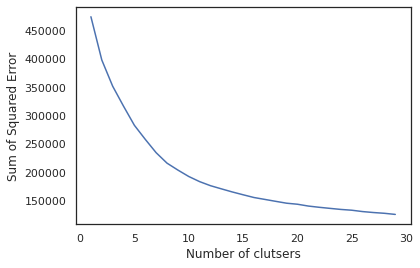

In [95]:
plt.plot(k,ssd)
plt.ylabel("Sum of Squared Error")
plt.xlabel("Number of clutsers");

## Implement K-Means

In [120]:
model = KMeans(n_clusters=20)
model.fit_transform(features)
cluster_labels = model.labels_

In [90]:
len(cluster_labels)

33901

In [106]:
def combine_cluster_labels(user_ids, labels):
  labels_df = pd.DataFrame(labels)
  cluster_df = pd.merge(user_ids, labels_df, left_index = True, right_index = True)
  cluster_df.columns = ['user', 'cluster']
  return cluster_df

In [17]:
len(user_ids)

33901

In [121]:
combine_cluster_labels(user_ids, cluster_labels)

,user,cluster
0,2,5
1,4,5
2,5,14
3,7,1
4,8,1
...,...,...
33896,2102054,8
33897,2102356,1
33898,2102680,0
33899,2102983,1


# PCA on user profile feature vectors to reduce dimensions

In [19]:
features = user_profile_df.loc[:,user_profile_df.columns != 'user']
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']

feature_names = list(user_profile_df.columns[1:])

In [20]:
print(f"There are {len(feature_names)} features for each user profile.")

There are 14 features for each user profile.


In [23]:
features.head()

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,6.106474,2.485388,0.961242,8.272010,0.850889,6.477594,-0.024296,4.571668,5.023412,1.456642,7.249771,7.360899,6.369323,2.570116
1,4.529980,-0.353377,0.440653,5.120792,-0.424767,2.368540,-0.024296,2.851031,2.667576,-0.438787,2.127032,0.865416,-0.231621,0.519419
2,2.427988,1.066006,4.084776,4.280467,-0.424767,5.828796,-0.024296,3.233395,1.281790,1.456642,5.542191,5.505047,2.702132,2.570116
3,-0.462250,-0.826504,-0.600526,-0.341319,-0.424767,-0.659184,-0.024296,-0.972608,-0.381153,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
4,0.063248,-0.826504,-0.600526,0.078843,-0.424767,-0.659184,-0.024296,-0.972608,0.173161,-0.438787,0.419453,-0.526473,-0.231621,-0.505930


## Covariance Plot

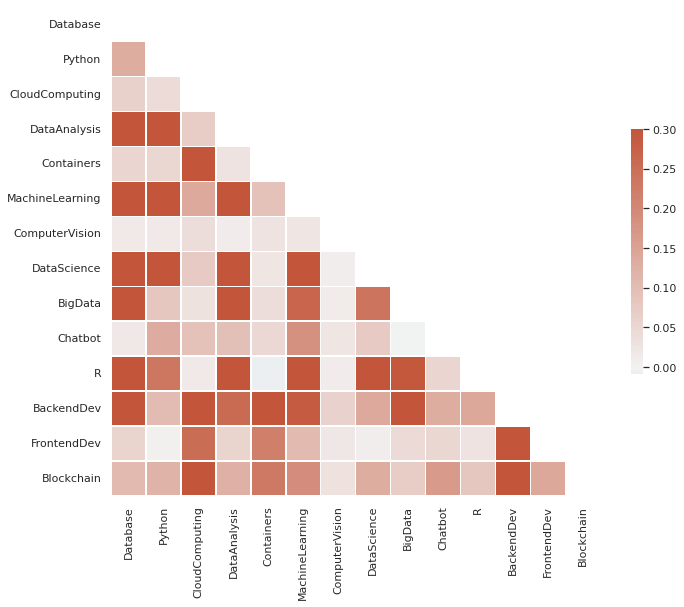

In [21]:
sns.set_theme(style = 'white')

# Compute the correlation matrix
corr = features.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap = True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask ,cmap = cmap, vmax = .3, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5},)

plt.show()

## Finding optimized number of components for PCA

In [25]:
explained_variance_ratio = []
for n in range(1,15):
  pca = PCA(n_components = n)
  pca.fit(features)
  explained_variance_ratio.append(np.sum(pca.explained_variance_ratio_))

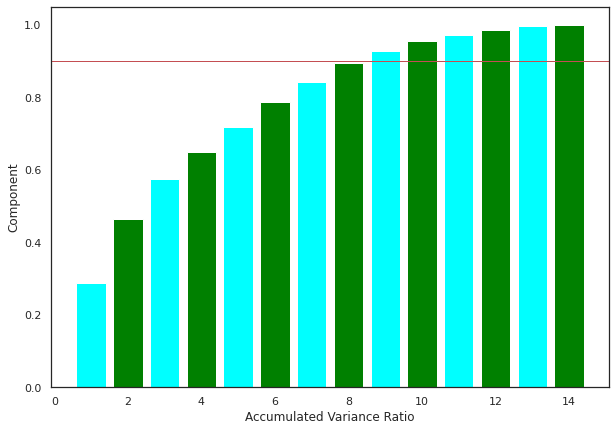

In [70]:
threshold_variance = 0.9
x = range(1,15)
plt.figure(figsize=(10,7))
plt.bar(x, explained_variance_ratio,color=['cyan','green'])
plt.axhline(threshold_variance, linewidth = 1, color = 'r')
plt.xlabel("Accumulated Variance Ratio")
plt.ylabel("Component");


Thus we can see that 8 components gives better explained variance ratio 

## Implement PCA

In [84]:
pca_model = PCA(n_components = 9)
principalComponents = pca_model.fit_transform(features)
print(f"Accumulated explained variance ratio is {np.sum(pca.explained_variance_ratio_)}")

Accumulated explained variance ratio is 0.9999999999999999


In [87]:
df = pd.DataFrame(data=principalComponents,
                        columns = [
                            "PC0","PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8"
                            ])
df.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,17.772494,0.200681,1.730609,2.567359,-3.825814,2.707154,0.681042,2.312613,0.868272
1,7.145199,-2.847481,2.358636,-0.576654,0.398803,-0.134533,0.549769,0.469033,0.033405
2,11.363270,1.873619,-1.522077,1.076144,-1.711688,0.883212,1.677582,2.937669,2.097639
3,-1.834033,-0.277462,0.564905,0.053470,-0.064440,0.165757,0.030956,0.039519,0.210887
4,-1.049125,-0.684767,1.072765,0.006371,-0.005695,0.118686,0.118559,0.559292,0.186379


In [88]:
final_df = pd.concat([user_ids, df],axis=1)
final_df

,user,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,2,17.772494,0.200681,1.730609,2.567359,-3.825814,2.707154,0.681042,2.312613,0.868272
1,4,7.145199,-2.847481,2.358636,-0.576654,0.398803,-0.134533,0.549769,0.469033,0.033405
2,5,11.363270,1.873619,-1.522077,1.076144,-1.711688,0.883212,1.677582,2.937669,2.097639
3,7,-1.834033,-0.277462,0.564905,0.053470,-0.064440,0.165757,0.030956,0.039519,0.210887
4,8,-1.049125,-0.684767,1.072765,0.006371,-0.005695,0.118686,0.118559,0.559292,0.186379
...,...,...,...,...,...,...,...,...,...,...
33896,2102054,0.633824,0.108815,-0.388871,-0.122665,-0.098364,0.358333,1.752049,1.486542,-0.523600
33897,2102356,-2.095339,0.135058,0.244727,-0.088185,0.025081,0.183641,0.046413,0.191709,0.260437
33898,2102680,0.625943,-0.547167,-1.692824,-0.630589,0.166632,0.676244,-0.055100,0.582091,1.703193
33899,2102983,-2.036832,-0.153534,0.162852,0.082651,-0.126419,0.255109,0.072496,0.113750,0.622900


# Implement K-Means and PCA 

In [122]:
kmeans_model = KMeans(n_clusters = 20)
kmeans_model.fit_transform(df)
cluster_labels = kmeans_model.labels_

In [125]:
final_cluster_df = combine_cluster_labels(user_ids, cluster_labels)
final_cluster_df.head()

,user,cluster
0,2,10
1,4,10
2,5,12
3,7,2
4,8,2


# Course Recommendation based on same cluster